<a href="https://colab.research.google.com/github/kerfriden/SurrOptim/blob/main/demo_surroptim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
try:
    import surroptim
except:
    !pip install -q "git+https://github.com/kerfriden/SurrOptim@main"

#!pip uninstall -y surroptim
!pip install -q "git+https://github.com/kerfriden/SurrOptim@main" --force-reinstall
#!pip install --upgrade git+https://github.com/kerfriden/SurrOptim.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


=== Test 1: Sparse Grid Sampling ===
Building your FEA sampler...
distribution type for dimension 0: uniform
bounds of distribution for dimension 0: [-2, 2.0]
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
... done building
Start computing 65 samples in parametric dimension 2 using SG
... done sampling


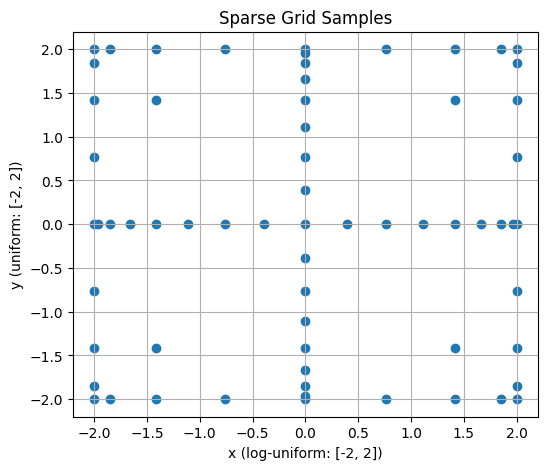


=== Test 1b: Sparse Grid with Log-Uniform ===
Building your FEA sampler...
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
... done building
Start computing 65 samples in parametric dimension 2 using SG
... done sampling


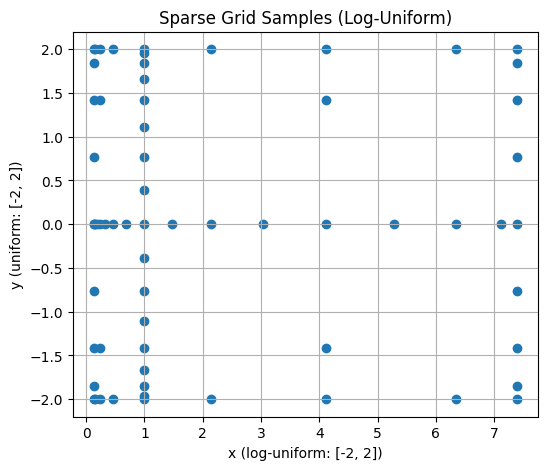

In [39]:
"""Demo script: SurrOptim sampling and metamodeling."""

import numpy as np
import matplotlib.pyplot as plt

from surroptim.sampler import sampler_cls
from surroptim.polynomial_meta_models import polynomial_lasso_regressor

# ============================================================================
# 1. Simple sparse grid sampling
# ============================================================================
print("=== Test 1: Sparse Grid Sampling ===")
sampler_sg = sampler_cls(
    distributions=["uniform", "uniform"],
    bounds=[[-2, 2.], [-2., 2.]],
    doe_type='SG'
)

sampler_sg.sample(n_samples=5)

plt.figure(figsize=(6, 5))
plt.scatter(sampler_sg.X[:, 0], sampler_sg.X[:, 1])
plt.xlabel("x (log-uniform: [-2, 2])")
plt.ylabel("y (uniform: [-2, 2])")
plt.grid()
plt.title("Sparse Grid Samples")
plt.show()

# ============================================================================
# 1b. Sparse grid with log-uniform (requires positive bounds)
# ============================================================================
print("\n=== Test 1b: Sparse Grid with Log-Uniform ===")
sampler_sg_log = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    doe_type='SG'
)

sampler_sg_log.sample(N=5)

plt.figure(figsize=(6, 5))
plt.scatter(sampler_sg_log.X[:, 0], sampler_sg_log.X[:, 1])
plt.xlabel("x (log-uniform: [-2, 2])")
plt.ylabel("y (uniform: [-2, 2])")
plt.grid()
plt.title("Sparse Grid Samples (Log-Uniform)")
plt.show()

doe.X.shape (20, 2)


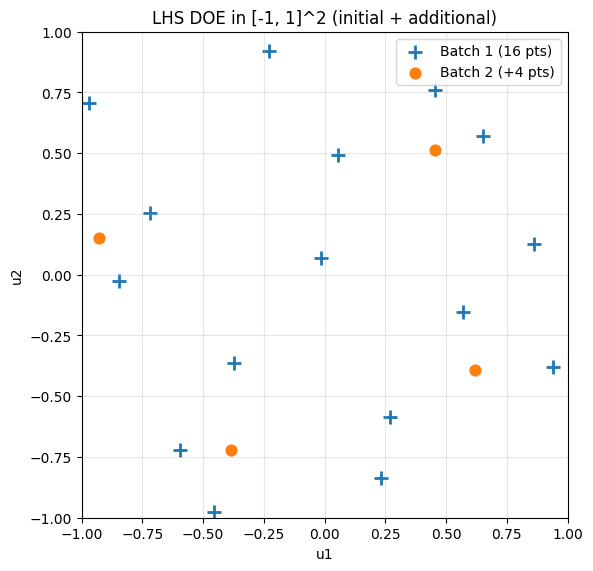

In [40]:
import matplotlib.pyplot as plt
from surroptim.doe_strategies import DOEFactory

doe = DOEFactory.create('LHS', 2, seed=42)
X = doe.sample(16)

# request additional points and ensure internal state grows
X_more = doe.sample(4, as_additional_points=True)

print("doe.X.shape",doe.X.shape)

fig, ax = plt.subplots(figsize=(6, 6))  # <-- you were missing this

# First batch
ax.scatter(X[:, 0], X[:, 1], s=90, marker='+', linewidths=2,
           label='Batch 1 (16 pts)')

# Additional points
ax.scatter(X_more[:, 0], X_more[:, 1], s=60, marker='o',
           label='Batch 2 (+4 pts)')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_title('LHS DOE in [-1, 1]^2 (initial + additional)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



=== Test 2: Incremental Sampling with Sigmoid QoI ===


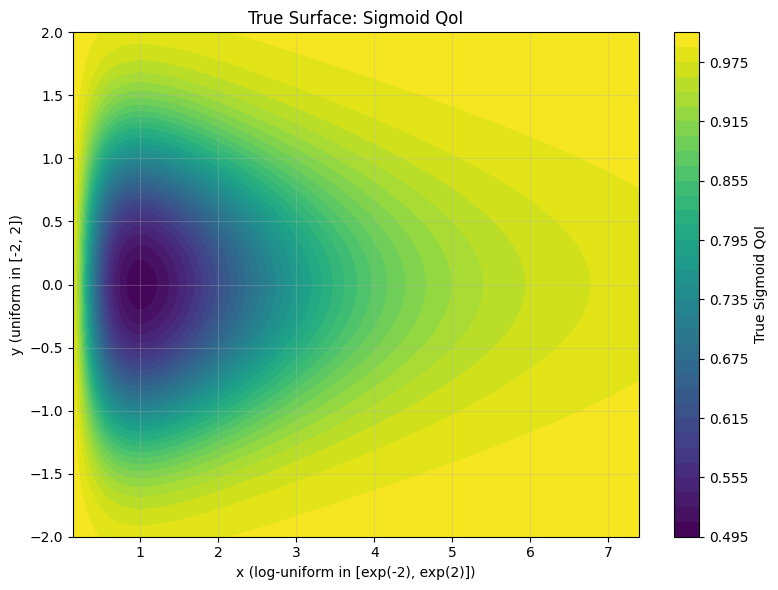

In [41]:
# ============================================================================
# 2. Incremental sampling with QoI evaluation and active_keys
# ============================================================================
print("\n=== Test 2: Incremental Sampling with Sigmoid QoI ===")

all_parameters = {"x": 0, "y": 1, "unused": 0}

def sigmoid_qoi(active_param) -> np.ndarray:
    """QoI: [sum, sigmoid]"""
    for key, value in active_param.items():
        all_parameters[key] = value
    x = all_parameters["x"]
    y = all_parameters["y"]
    s = np.log(x)**2 + y**2
    sig = 1.0 / (1.0 + np.exp(-s))
    return np.vstack([s, sig]).T

# --- True surface using the existing QoI (no points) ---
fig, ax = plt.subplots(figsize=(8, 6))

nx, ny = 200, 200
xg = np.linspace(np.exp(-2), np.exp(2), nx)
yg = np.linspace(-2.0, 2.0, ny)
Xg, Yg = np.meshgrid(xg, yg)

# Evaluate QoI on the grid by calling sigmoid_qoi for each (x, y)
XX = Xg.ravel()
YY = Yg.ravel()

qoi_vals = np.array([sigmoid_qoi({'x': x, 'y': y})[0] for x, y in zip(XX, YY)])
# qoi_vals shape: (nx*ny, 2) with columns [s, sigmoid]

Sig_true = qoi_vals[:, 1].reshape(Yg.shape)   # 2nd column = sigmoid

cf = ax.contourf(Xg, Yg, Sig_true, levels=40, cmap="viridis")
plt.colorbar(cf, ax=ax, label="True Sigmoid QoI")

ax.set_xlabel("x (log-uniform in [exp(-2), exp(2)])")
ax.set_ylabel("y (uniform in [-2, 2])")
ax.set_title("True Surface: Sigmoid QoI")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Building your FEA sampler...
parameter dimension 0: x
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
parameter dimension 1: y
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point: [[0.  0.5]]
n_out: 2
... done building
Start computing 5 samples in parametric dimension 2 using QRS
... done sampling
First batch: 5 samples
Start computing 5 additional samples in parametric dimension 2 using QRS
... done sampling
After incremental: 10 total samples


/tmp/ipython-input-1334020684.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_before[:, 0], X_before[:, 1], c=cvals, cmap="viridis",


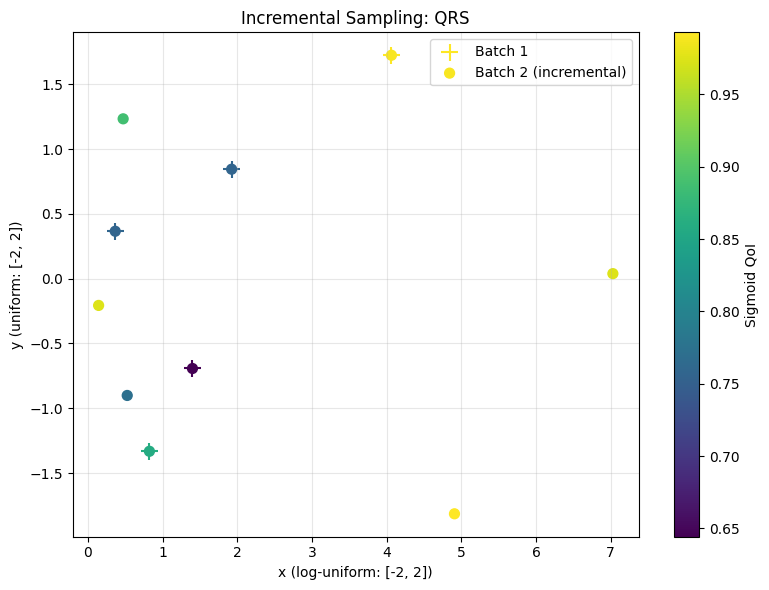

In [42]:
sampler = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    active_keys=['x', 'y'],
    qoi_fn=sigmoid_qoi,
    DOE_type='QRS',
    seed=0
)

# First batch
sampler.sample(N=5)
X_before = sampler.X.copy()
Y_before = sampler.Y.copy()

print(f"First batch: {len(X_before)} samples")

# Incremental sampling
sampler.sample(N=5, as_additional_points=True)
print(f"After incremental: {len(sampler.X)} total samples")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# First batch
cvals = Y_before[:,1]
ax.scatter(X_before[:, 0], X_before[:, 1], c=cvals, cmap="viridis",
          s=150, marker='+', label='Batch 1', edgecolors='black', linewidths=1.5)

# Incremental batch
cvals_new = sampler.Y[:,1]
ax.scatter(sampler.X[:, 0], sampler.X[:, 1],
          c=cvals_new, cmap="viridis", s=50, label='Batch 2 (incremental)')

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Incremental Sampling: QRS")
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(ax.collections[0], ax=ax, label='Sigmoid QoI')
plt.tight_layout()
plt.show()


=== Test 3: Polynomial Model + Grid Prediction ===
Lasso weights: 277 zero, 13 non-zero (zero fraction 0.955)
Model trained on 10 samples
Building your FEA sampler...
parameter dimension 0: x
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
parameter dimension 1: y
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point: [[0.  0.5]]
n_out: 2
... done building
Start computing 30 samples in parametric dimension 2 using QRS
... done sampling


/usr/local/lib/python3.12/dist-packages/surroptim/polynomial_meta_models.py:86: RuntimeWarning: Lasso sparsity is outside 10%-90% range; consider tuning alpha.
  warnings.warn(


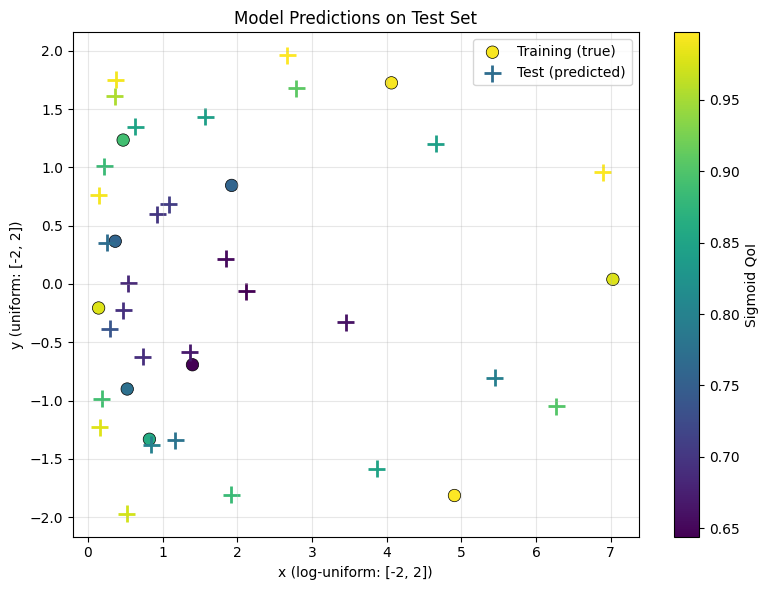

In [43]:
# ============================================================================
# 3. Train metamodel and predict on grid
# ============================================================================
print("\n=== Test 3: Polynomial Model + Grid Prediction ===")

model = polynomial_lasso_regressor(order=6, coeff_reg=1e-3, SG=True)
model.train(sampler.X_reference, sampler.Y)

print(f"Model trained on {len(sampler.X)} samples")

# Test set
sampler_test = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    active_keys=['x', 'y'],
    qoi_fn=sigmoid_qoi,
    DOE_type='QRS',
    seed=1
)
sampler_test.sample(N=30)

preds = model.predict(sampler_test.X_reference)

# Visualize: training vs test predictions
fig, ax = plt.subplots(figsize=(8, 6))

# Training points (true QoI)
cvals_train = sampler.Y[:, 1]
sc_train = ax.scatter(sampler.X[:, 0], sampler.X[:, 1], c=cvals_train,
                      cmap="viridis", s=80, label='Training (true)',
                      edgecolors='black', linewidths=0.5)

# Test predictions
cvals_test = preds[:, 1]
ax.scatter(sampler_test.X[:, 0], sampler_test.X[:, 1], marker="+",
          c=cvals_test, cmap="viridis", s=150, label='Test (predicted)', linewidths=2)

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Model Predictions on Test Set")
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(sc_train, ax=ax, label='Sigmoid QoI')
plt.tight_layout()
plt.show()

In [44]:
from surroptim.util import r2_score

preds = model.predict(sampler.X_reference)
r2 = r2_score(sampler.Y[:,1], preds[:, 1])
print("r2 for training set :",r2)

preds = model.predict(sampler_test.X_reference)
r2 = r2_score(sampler_test.Y[:,1], preds[:, 1])
print("r2 for test set :",r2)

r2 for training set : 0.9609421493071426
r2 for test set : 0.7471433607378413



=== Test 4: Contour Grid Prediction ===


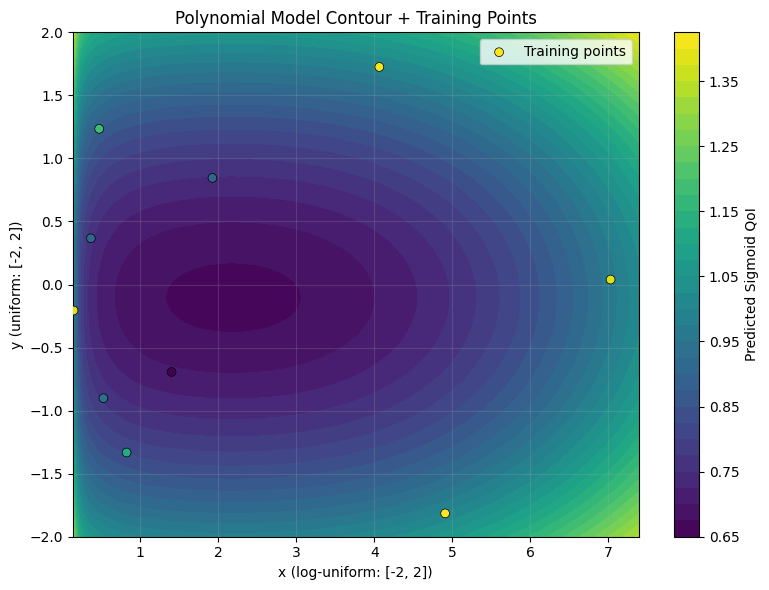


✓ Demo completed successfully!


In [45]:
# ============================================================================
# 4. Contour plot on grid
# ============================================================================
print("\n=== Test 4: Contour Grid Prediction ===")

# Physical space grid
xmin, xmax = -1, 1
ymin, ymax = -1, 1
ng = 100

xx = np.linspace(xmin, xmax, ng)
yy = np.linspace(ymin, ymax, ng)
Xg, Yg = np.meshgrid(xx, yy)

grid_ref = np.c_[Xg.ravel(), Yg.ravel()]  # (ng*ng, 2) in physical space

# Convert to reference space

# Predict on grid
pred_grid = model.predict(grid_ref)  # shape (ng*ng, n_out)
Z = pred_grid[:, 1].reshape(ng, ng)  # QoI[1]

Xg, Yg = np.meshgrid(xx, yy)

U = np.c_[Xg.ravel(), Yg.ravel()]
U_phys = sampler.reference_to_physical(U)  # Normalize grid for prediction
Xg_phys = U_phys[:, 0].reshape(Xg.shape)          # (ny, nx)
Yg_phys = U_phys[:, 1].reshape(Yg.shape)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(Xg_phys, Yg_phys, Z, levels=30, cmap="viridis")
cbar = plt.colorbar(cf, ax=ax, label="Predicted Sigmoid QoI")

# Overlay training points
ax.scatter(sampler.X[:, 0], sampler.X[:, 1],
           c=sampler.Y[:, 1], cmap="viridis",
           edgecolors="black", linewidths=0.5, s=40,
           label="Training points", zorder=5)

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Polynomial Model Contour + Training Points")
ax.legend()
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print("\n✓ Demo completed successfully!")

In [46]:
from surroptim.param_processor import params_cls
from surroptim.sampler import sampler_new_cls

def sigmoid_qoi(params):
    x = float(params[0])
    y = float(params[1])
    p = float(params[2])
    s = np.log(x)**2 + y ** p
    sig = 1.0 / (1.0 + np.exp(-s))
    return np.vstack([s, sig]).T

# init params: single 3-element array 'a' with two active components (indices 0 and 1)
init_params = np.array([1.0, 0.0, 0.0])
active_specs = {
    "a0": {"select": np.array([1, 0, 0], bool), "lower": np.exp(-2.0), "upper": np.exp(2.0), "scale": "log"},
    "a1": {"select": np.array([0, 1, 0], bool), "lower": -2.0, "upper": 2.0, "scale": "linear"},
}

params = params_cls(init_params=init_params, active_specs=active_specs)

sampler = sampler_new_cls(
    params=params,
    doe_type="QRS",
    seed=0,
    qoi_fn=sigmoid_qoi,
)

# first batch
sampler.sample(N=8, as_additional_points=False)
assert sampler.X.shape[0] == 8 and sampler.X.shape[1] == 2
assert sampler.Y.shape == (8, 2)

# second batch appended
sampler.sample(N=8, as_additional_points=True)
assert sampler.X.shape[0] == 16 and sampler.X.shape[1] == 2
assert sampler.Y.shape == (16, 2)

Building sampler_new_cls using external params processor...
param processor dim: 2
n_out not provided -> calling QoI for automatic determination


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
from surroptim.param_processor import params_cls
from surroptim.sampler import sampler_new_cls

def sigmoid_qoi(params_dict) -> np.ndarray:
    """QoI: [sum, sigmoid] where x=params['a'][0], y=params['a'][1]
    Uses scalar `power` from params_dict (default 2.0) as exponent for y."""
    A = params_dict.get("a")
    if A is None:
        raise KeyError("expected parameter 'a' in params dict")
    x = float(A[0])
    y = float(A[1])
    p = float(params_dict.get("power", 2.0))
    s = np.log(x)**2 + y ** p
    sig = 1.0 / (1.0 + np.exp(-s))
    return np.vstack([s, sig]).T

# init params: single 3-element array 'a' with two active components (indices 0 and 1)
init_params = {"a": np.array([1.0, 0.0, 0.0]), "power": 2.0}
active_specs = {
    "a0": {"param": "a", "select": np.array([1, 0, 0], bool), "lower": np.exp(-2.0), "upper": np.exp(2.0), "scale": "log"},
    "a1": {"param": "a", "select": np.array([0, 1, 0], bool), "lower": -2.0, "upper": 2.0, "scale": "linear"},
}

params = params_cls(init_params=init_params, active_specs=active_specs)

sampler = sampler_new_cls(
    params=params,
    doe_type="QRS",
    seed=0,
    qoi_fn=sigmoid_qoi,
)

# first batch
sampler.sample(N=8, as_additional_points=False)
assert sampler.X.shape[0] == 8 and sampler.X.shape[1] == 2
assert sampler.Y.shape == (8, 2)

# second batch appended
sampler.sample(N=8, as_additional_points=True)
assert sampler.X.shape[0] == 16 and sampler.X.shape[1] == 2
assert sampler.Y.shape == (16, 2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Training points (true QoI)
cvals_train = sampler.Y[:, 1]
sc_train = ax.scatter(sampler.X[:, 0], sampler.X[:, 1], c=cvals_train,
                      cmap="viridis", s=80, label='Training (true)',
                      edgecolors='black', linewidths=0.5)
ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Model Predictions on Test Set")
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(sc_train, ax=ax, label='Sigmoid QoI')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

cvals = sampler.Y[:, 1]   # must match X_reference length
sc = ax.scatter(
    sampler.X_reference[:, 0], sampler.X_reference[:, 1],
    c=cvals, cmap="viridis", s=80,
    edgecolors="black", linewidths=0.5,
    label="Reference (true)"
)

ax.set_xlabel("x (log-uniform in [exp(-2), exp(2)])")
ax.set_ylabel("y (uniform in [-2, 2])")
ax.set_title("Reference points (true QoI)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.colorbar(sc, ax=ax, label="Sigmoid QoI")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

cvals = sampler.Y[:, 1]   # must match X_reference length
sc = ax.scatter(
    sampler.X_gaussian[:, 0], sampler.X_gaussian[:, 1],
    c=cvals, cmap="viridis", s=80,
    edgecolors="black", linewidths=0.5,
    label="Reference (true)"
)

ax.set_xlabel("x (log-uniform in [exp(-2), exp(2)])")
ax.set_ylabel("y (uniform in [-2, 2])")
ax.set_title("Reference points (true QoI)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.colorbar(sc, ax=ax, label="Sigmoid QoI")
fig.tight_layout()
plt.show()

In [ ]:
model = polynomial_lasso_regressor(order=6, coeff_reg=1e-3, SG=True)
model.train(sampler.X_reference, sampler.Y)

print(f"Model trained on {len(sampler.X)} samples")

preds = model.predict(sampler.X_reference)
r2 = r2_score(sampler.Y[:,1], preds[:, 1])
print("r2 for training set :",r2)

In [ ]:
import numpy as np
from scipy.optimize import minimize

def obj(z):
    #print("z",z)
    #z = params.gauss_to_unit(z)
    z = params.gaussian_to_reference(z)
    #print("z",z)
    pred = model.predict(z.reshape([1,-1]))
    return float(pred[0, 1])  # sigmoid QoI (surrogate)

# good starting guess: best predicted among existing points)
x0 = np.zeros_like(sampler.X_reference[0])

res = minimize(obj, x0=x0, method="L-BFGS-B")

print("Success:", res.success, res.message)
print("x* =", res.x)
print("min pred sigmoid =", res.fun)

print("opt in reference space",params.gauss_to_unit(res.x))
print("opt in physical space",params.gauss_to_unit(res.x))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Surrogate surface in PHYSICAL space + optimum point ---

# 1) Build a grid in REFERENCE space (where the surrogate is trained)
ng = 250
u1 = np.linspace(-1.0, 1.0, ng)
u2 = np.linspace(-1.0, 1.0, ng)
U1, U2 = np.meshgrid(u1, u2)
grid_ref = np.c_[U1.ravel(), U2.ravel()]  # (ng*ng, 2)

# 2) Predict surrogate on the reference grid (take sigmoid output = col 1)
Z = model.predict(grid_ref)[:, 1].reshape(ng, ng)

# 3) Map grid to PHYSICAL space for axes
grid_phys = params.reference_to_physical(grid_ref)
X_phys = grid_phys[:, 0].reshape(ng, ng)
Y_phys = grid_phys[:, 1].reshape(ng, ng)

# 4) Map the optimum to PHYSICAL space
z_ref_opt = params.gauss_to_unit(res.x)
z_phys_opt = params.gauss_to_physical(z_ref_opt)

# 5) Plot
fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(X_phys, Y_phys, Z, levels=40, cmap="viridis")
fig.colorbar(cf, ax=ax, label="Predicted sigmoid QoI")

ax.plot(z_phys_opt[0], z_phys_opt[1], marker="x", markersize=12,
        markeredgewidth=2.5, color="red", label="Optimum")

ax.set_xlabel("x (physical)")
ax.set_ylabel("y (physical)")
ax.set_title("Surrogate surface (physical space) + optimum")
ax.grid(True, alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()
